In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from tqdm import tqdm
import time

train = pd.read_csv("CSV_train.csv",low_memory=False,delimiter=';')
test=pd.read_csv("CSV_test.csv",low_memory=False,delimiter=',')
hidden=pd.read_csv("CSV_hidden_test.csv",low_memory=False,delimiter=',')

In [2]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136786 entries, 0 to 136785
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   WELL                              136786 non-null  object 
 1   DEPTH_MD                          136786 non-null  float64
 2   X_LOC                             136727 non-null  float64
 3   Y_LOC                             136727 non-null  float64
 4   Z_LOC                             136727 non-null  float64
 5   GROUP                             136786 non-null  object 
 6   FORMATION                         129712 non-null  object 
 7   CALI                              131141 non-null  float64
 8   RSHA                              39097 non-null   float64
 9   RMED                              136199 non-null  float64
 10  RDEP                              136727 non-null  float64
 11  RHOB                              119826 non-null  f

In [3]:
# storing length of datasets 
train_len = train.shape[0] 
test_len = test.shape[0]
All_data = pd.concat((train,test,hidden)).reset_index(drop=True) 

lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}
All_data['Lithology'] = All_data['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
All_data

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,Lithology
0,15/9-13,494.5280,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0,Shale
1,15/9-13,494.6800,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0,Shale
2,15/9-13,494.8320,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0,Shale
3,15/9-13,494.9840,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0,Shale
4,15/9-13,495.1360,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429689,35/9-7,2973.2988,536096.06250,6793022.0,-2943.444580,BAAT GP.,Etive Fm.,8.276272,NaN,2.820439,...,136.911575,NaN,0.502458,NaN,2.311106,24.306124,NaN,65000,2.0,Shale
1429690,35/9-7,2973.4508,536096.06250,6793022.0,-2943.595947,BAAT GP.,Etive Fm.,8.267273,NaN,3.020778,...,137.583923,NaN,0.374753,NaN,1.853418,22.201078,NaN,65000,2.0,Shale
1429691,35/9-7,2973.6028,536096.06250,6793022.0,-2943.747559,BAAT GP.,Etive Fm.,8.250099,NaN,2.795711,...,138.310898,NaN,0.211487,NaN,1.325961,20.096741,NaN,65000,2.0,Shale
1429692,35/9-7,2973.7548,536096.06250,6793022.0,-2943.899170,BAAT GP.,Etive Fm.,NaN,NaN,2.658694,...,137.592819,NaN,0.147950,NaN,1.260347,17.992323,NaN,65000,2.0,Shale


In [4]:
#dropping columns with high missing values
drop_cols = ['SGR', 'ROPA', 'RXO', 'MUDWEIGHT','DCAL','RMIC','FORCE_2020_LITHOFACIES_CONFIDENCE']
All_data_drop = All_data.drop(drop_cols, axis=1)


In [5]:
All_data_drop

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,NPHI,PEF,DTC,SP,BS,ROP,DTS,DRHO,FORCE_2020_LITHOFACIES_LITHOLOGY,Lithology
0,15/9-13,494.5280,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,-0.574928,65000,Shale
1,15/9-13,494.6800,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,-0.570188,65000,Shale
2,15/9-13,494.8320,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,-0.574245,65000,Shale
3,15/9-13,494.9840,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,-0.586315,65000,Shale
4,15/9-13,495.1360,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,NaN,38.495632,160.128342,24.104078,NaN,57.483765,NaN,-0.597914,65000,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429689,35/9-7,2973.2988,536096.06250,6793022.0,-2943.444580,BAAT GP.,Etive Fm.,8.276272,NaN,2.820439,...,NaN,NaN,75.260658,NaN,8.5,15.195305,136.911575,0.502458,65000,Shale
1429690,35/9-7,2973.4508,536096.06250,6793022.0,-2943.595947,BAAT GP.,Etive Fm.,8.267273,NaN,3.020778,...,NaN,NaN,74.868301,NaN,8.5,15.770223,137.583923,0.374753,65000,Shale
1429691,35/9-7,2973.6028,536096.06250,6793022.0,-2943.747559,BAAT GP.,Etive Fm.,8.250099,NaN,2.795711,...,NaN,NaN,74.848122,NaN,8.5,16.418465,138.310898,0.211487,65000,Shale
1429692,35/9-7,2973.7548,536096.06250,6793022.0,-2943.899170,BAAT GP.,Etive Fm.,NaN,NaN,2.658694,...,NaN,NaN,74.964027,NaN,8.5,17.037945,137.592819,0.147950,65000,Shale


In [6]:
All_data_drop.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC',
       'SP', 'BS', 'ROP', 'DTS', 'DRHO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'Lithology'],
      dtype='object')

In [7]:
#Inputing missing values by introducing median 
from sklearn.impute import SimpleImputer

numeric_header=['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC',
       'SP', 'BS', 'ROP', 'DTS', 'DRHO', 'FORCE_2020_LITHOFACIES_LITHOLOGY'
       ]
categorical_header=['WELL','GROUP', 'FORMATION','Lithology']
numeric=All_data_drop.select_dtypes(include=[np.number])
categorical= All_data_drop.select_dtypes(exclude=[np.number])
miss = SimpleImputer(missing_values=np.nan, strategy='median')
miss.fit(numeric)
numeric_imp = miss.fit_transform(numeric)
numeric_imp=pd.DataFrame(numeric_imp, columns=numeric_header)
miss2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
miss2.fit(categorical)
categorical_imp = miss2.fit_transform(categorical)
categorical_imp=pd.DataFrame(categorical_imp, columns=categorical_header)
frames = [numeric_imp,categorical_imp]
  
result = pd.concat(frames,axis=1, join='inner')
result

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,SP,BS,ROP,DTS,DRHO,FORCE_2020_LITHOFACIES_LITHOLOGY,WELL,GROUP,FORMATION,Lithology
0,494.5280,437641.96875,6470972.5,-469.501831,19.480835,1.398049,1.611410,1.798681,1.884186,80.200851,...,24.612379,12.250001,34.636410,189.362198,-0.574928,65000.0,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
1,494.6800,437641.96875,6470972.5,-469.653809,19.468800,1.398049,1.618070,1.795641,1.889794,79.262886,...,23.895531,12.250001,34.636410,189.362198,-0.570188,65000.0,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
2,494.8320,437641.96875,6470972.5,-469.805786,19.468800,1.398049,1.626459,1.800733,1.896523,74.821999,...,23.916357,12.250001,34.779556,189.362198,-0.574245,65000.0,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
3,494.9840,437641.96875,6470972.5,-469.957794,19.459282,1.398049,1.621594,1.801517,1.891913,72.878922,...,23.793688,12.250001,39.965164,189.362198,-0.586315,65000.0,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
4,495.1360,437641.96875,6470972.5,-470.109772,19.453100,1.398049,1.602679,1.795299,1.880034,71.729141,...,24.104078,12.250001,57.483765,189.362198,-0.597914,65000.0,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429689,2973.2988,536096.06250,6793022.0,-2943.444580,8.276272,1.398049,2.820439,3.158570,2.331407,90.720284,...,54.270451,8.500000,15.195305,136.911575,0.502458,65000.0,35/9-7,BAAT GP.,Etive Fm.,Shale
1429690,2973.4508,536096.06250,6793022.0,-2943.595947,8.267273,1.398049,3.020778,3.332977,2.331407,87.062027,...,54.270451,8.500000,15.770223,137.583923,0.374753,65000.0,35/9-7,BAAT GP.,Etive Fm.,Shale
1429691,2973.6028,536096.06250,6793022.0,-2943.747559,8.250099,1.398049,2.795711,3.044179,2.331407,86.115921,...,54.270451,8.500000,16.418465,138.310898,0.211487,65000.0,35/9-7,BAAT GP.,Etive Fm.,Shale
1429692,2973.7548,536096.06250,6793022.0,-2943.899170,12.515673,1.398049,2.658694,2.847681,2.331407,89.497131,...,54.270451,8.500000,17.037945,137.592819,0.147950,65000.0,35/9-7,BAAT GP.,Etive Fm.,Shale


In [8]:
# encoding categorical variables
result['GROUP_encoded'] = result['GROUP'].astype('category')
result['GROUP_encoded'] = result['GROUP_encoded'].cat.codes

result['FORMATION_encoded'] = result['FORMATION'].astype('category')
result['FORMATION_encoded'] = result['FORMATION_encoded'].cat.codes

result['WELL_encoded'] = result['WELL'].astype('category')
result['WELL_encoded'] = result['WELL_encoded'].cat.codes

result['Lithology_encoded'] = result['FORCE_2020_LITHOFACIES_LITHOLOGY'].astype('category')
result['Lithology_encoded'] = result['Lithology_encoded'].cat.codes

In [9]:
train_imp = result[:train_len].copy()
test_imp = result[train_len:(train_len+test_len)].copy()
hidden_imp = result[(train_len+test_len):].copy()

In [10]:
print(train_imp.shape)
print(test_imp.shape)
print(hidden_imp.shape)

(1170511, 27)
(136786, 27)
(122397, 27)


In [11]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
x_header=['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DRHO',
       'GROUP_encoded', 'FORMATION_encoded', 'WELL_encoded']
y_header=['Lithology_encoded']
x_train = train_imp[x_header]
y_train = train_imp[y_header]
x_test = test_imp[x_header]
y_test = test_imp[y_header]
x_hidden = hidden_imp[x_header]
y_hidden = hidden_imp[y_header]

##Min-Max scaler 
scaler = MinMaxScaler()
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_hidden_scaled = x_hidden.copy()

x_train_scaled.iloc[:,:18] = scaler.fit_transform(x_train_scaled.iloc[:,:18])
x_test_scaled.iloc[:,:18] = scaler.transform(x_test_scaled.iloc[:,:18])
x_hidden_scaled.iloc[:,:18] = scaler.transform(x_hidden_scaled.iloc[:,:18])

In [12]:
from sklearn.model_selection import cross_val_score

new_train = pd.concat((x_train_scaled, pd.DataFrame(y_train, columns=["Lithology_encoded"])), axis=1)

# #Randomly sampling data
# sampled_train = new_train.sample(n=50000, random_state=0)


# #Spliting training data
# x_train_sam = sampled_train.drop(["Lithology_encoded"], axis=1)
# y_train_sam = sampled_train["Lithology_encoded"]


In [13]:
#X_train, X_test, Y_train, Y_test = train_test_split( X, y, test_size=0.10, random_state=42,stratify=y)

In [14]:
# A = np.load('penalty_matrix.npy')
# def score(y_true, y_pred):
#     S = 0.0
#     y_true = y_true.astype(int)
#     y_pred = y_pred.astype(int)
#     for i in range(0, y_true.shape[0]):
#         S -= A[y_true[i], y_pred[i]]
#     return S/y_true.shape[0]

In [15]:
+#Supervised Algorithms
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsRegressor
from pprint import pprint
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
import xgboost
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
#Comparing base models accuracies by using k-fold cross validation - 10 folds

from sklearn.model_selection import cross_val_score

model_rf = RandomForestClassifier()
                                    


model_rf.fit(x_train_sam, y_train_sam.values.ravel())
             
# train_pred_rf = model_rf.predict(x_train)
# open_pred_rf = model_rf.predict(x_test)
# hidden_pred_rf = model_rf.predict(x_hidden)
#Printing Reports 


C:\Users\Ayori\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [16]:
# from sklearn.metrics import classification_report, accuracy_score
# print('-----------------------TRAIN SET REPORT---------------------')
# print("Open set RMSE:", np.sqrt(mean_squared_error(y_train, train_pred_rf)))
# print('Open set penalty matrix score:', score(y_train.values, train_pred_rf))
# print('Open set report:', classification_report(y_train, train_pred_rf))
# print('-----------------------OPEN SET REPORT---------------------')
# print("Open set RMSE:", np.sqrt(mean_squared_error(y_test, open_pred_rf)))
# print('Open set penalty matrix score:', score(y_test.values, open_pred_rf))
# print('Open set report:', classification_report(y_test, open_pred_rf))
# print('-----------------------HIDDEN SET REPORT---------------------')
# print("Hidden set RMSE:", np.sqrt(mean_squared_error(y_hidden, hidden_pred_rf)))
# print('Hidden set penalty matrix score:', score(y_hidden.values, hidden_pred_rf))
# print('Hidden set report:', classification_report(y_hidden, hidden_pred_rf))

In [17]:
# def grid_search(model):
#     param_grid = {'n_estimators': [100, 150,200],
#            'max_depth': [10,15,20],'max_features': ['auto', 'sqrt'],'min_samples_leaf' : [1, 2, 4],
#            'criterion': ['gini', 'entropy']}
#     model_cv = model_selection.GridSearchCV(estimator=model, param_grid=param_grid,
#                                           scoring='f1_weighted', verbose=10, n_jobs=1, cv=10)
#     model_cv.fit(x_train_sam, y_train_sam)

#     print("Best score is: {}".format(model_cv.best_score_))
#     print("Tuned Model Parameter: {}".format(model_cv.best_params_))

In [18]:
# grid_search(model_rf)

In [19]:

model_rf_tuned = RandomForestClassifier(criterion='entropy',max_depth=20, max_features='auto', min_samples_leaf= 1, n_estimators=150)

# Fit the regressor to the training data
model_rf_tuned.fit(x_train_scaled, y_train.values.ravel())

# Prediction
train_pred_rf = model_rf_tuned.predict(x_train_scaled)
open_pred_rf = model_rf_tuned.predict(x_test_scaled)
hidden_pred_rf = model_rf_tuned.predict(x_hidden_scaled)
#Printing Reports 
#Printing Reports


In [20]:
A = np.load('penalty_matrix.npy')
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [21]:
from sklearn.metrics import classification_report, accuracy_score
print('-----------------------TRAIN SET REPORT---------------------')
print("Open set RMSE:", np.sqrt(mean_squared_error(y_train, train_pred_rf)))
print('Open set penalty matrix score:', score(y_train.values, train_pred_rf))
print('Open set report:', classification_report(y_train, train_pred_rf))
print('-----------------------OPEN SET REPORT---------------------')
print("Open set RMSE:", np.sqrt(mean_squared_error(y_test, open_pred_rf)))
print('Open set penalty matrix score:', score(y_test.values, open_pred_rf))
print('Open set report:', classification_report(y_test, open_pred_rf))
print('-----------------------HIDDEN SET REPORT---------------------')
print("Hidden set RMSE:", np.sqrt(mean_squared_error(y_hidden, hidden_pred_rf)))
print('Hidden set penalty matrix score:', score(y_hidden.values, hidden_pred_rf))
print('Hidden set report:', classification_report(y_hidden, hidden_pred_rf))

-----------------------TRAIN SET REPORT---------------------
Open set RMSE: 0.29347314466068763
Open set penalty matrix score: [-0.05015908]
Open set report:               precision    recall  f1-score   support

           0       0.99      0.97      0.98    168937
           1       0.98      1.00      0.99    720803
           2       0.97      0.94      0.96    150455
           3       1.00      0.91      0.95     56320
           4       1.00      1.00      1.00     10513
           5       1.00      0.66      0.80      1688
           6       0.99      0.98      0.99     33329
           7       1.00      1.00      1.00      1085
           8       1.00      1.00      1.00      8213
           9       1.00      0.98      0.99      3820
          10       1.00      1.00      1.00       103
          11       0.99      0.99      0.99     15245

    accuracy                           0.98   1170511
   macro avg       0.99      0.95      0.97   1170511
weighted avg       0.98      0

C:\Users\Ayori\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ayori\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ayori\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hidden set penalty matrix score: [-0.55906293]
Hidden set report:               precision    recall  f1-score   support

           0       0.78      0.78      0.78     14045
           1       0.85      0.95      0.90     71827
           2       0.59      0.26      0.36     12283
           3       0.59      0.61      0.60      8374
           4       0.62      0.47      0.53      2905
           5       0.00      0.00      0.00       287
           6       0.34      0.27      0.30      4396
           7       0.73      0.62      0.67       597
           8       0.99      0.99      0.99      6498
           9       0.88      0.65      0.75       244
          11       0.66      0.55      0.60       941

    accuracy                           0.80    122397
   macro avg       0.64      0.56      0.59    122397
weighted avg       0.78      0.80      0.78    122397



In [72]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
facies_colors = ['#F4D03F','#7ccc19','#196F3D','#160599','#2756c4','#3891f0','#80d4ff','#87039e','#ec90fc','#FF4500','#000000','#DC7633']
facies_labels = ['SS', 'S-S', 'SH', 'MR', 'DOL','LIM', 'CH','HAL', 'AN', 'TF', 'CO', 'BS']


#Facies_color_map
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]
    
def pred_log(logs, well_num, facies_colors, n_pred):
    wells = logs['WELL'].unique()
    logs = logs[logs['WELL'] == wells[well_num]]
    logs = logs.sort_values(by='DEPTH_MD')        #Sorting log by depth
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    top = logs.DEPTH_MD.min()
    bot = logs.DEPTH_MD.max()
       
    f, ax = plt.subplots(nrows=1, ncols=(12+n_pred), figsize=(15, 12))
    log_colors = ['black', 'red', 'blue', 'green', 'purple','black', 'red', 'blue', 'green', 'purple', 'black', 'red', 'blue', 'green', 'purple', 'black', 'black', 'red', 'blue', 'green', 'purple', 'black', 'black', 'red', 'blue', 'green', 'purple', 'black']

    for i in range(7,18):
      ax[i-7].plot(logs.iloc[:,i], logs.DEPTH_MD, color=log_colors[i])
      ax[i-7].set_ylim(top, bot)
      #ax[i-7].set_xlim(logs.iloc[:,i].min(), logs.iloc[:,i].max())

      ax[i-7].set_xlabel(str(logs.columns[i]))
      ax[i-7].invert_yaxis()
      ax[i-7].grid()

    for j in range((-1-n_pred), 0):
      label = np.repeat(np.expand_dims(logs.iloc[:,j].values, 1), 100, 0)
      im = ax[j].imshow(label, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=12)
      ax[j].set_xlabel(str(logs.columns[j]))

    divider = make_axes_locatable(ax[-1])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((12*' ').join(['SS', 'S-S', 'SH', 'MR', 'DOL','LIM', 'CH','HAL', 'AN', 'TF', 'CO', 'BS']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
        
    f.suptitle('WELL LOGS '+str(wells[well_num]), fontsize=14,y=0.94)

In [47]:
#Storing results
test_rf_tune = test.copy()
hidden_rf_tune = hidden.copy()
#Saving Results
test_rf_tune['RF_TUNED'] = open_pred_rf
hidden_rf_tune['RF_TUNED'] = hidden_pred_rf

test_rf_tune.to_csv('test_rf_tune.csv', index=False)
hidden_rf_tune.to_csv('hidden_rf_tune.csv', index=False)

In [48]:
test_rf_tune = pd.read_csv('test_rf_tune.csv')
hidden_rf_tune = pd.read_csv('hidden_rf_tune.csv')

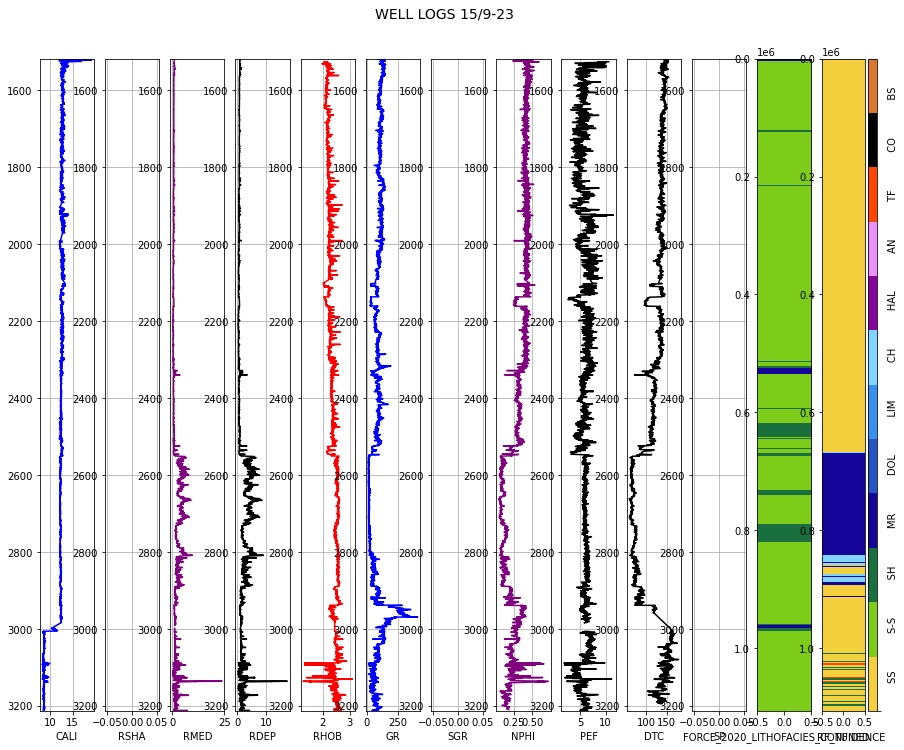

In [73]:
#Plotting predictions - HIDDEN DATASET
for i in range(1):
  pred_log(hidden_rf_tune, i, facies_colors, 1)

In [51]:
facies_color_map

{'SS': '#F4D03F',
 'S-S': '#7ccc19',
 'SH': '#196F3D',
 'MR': '#160599',
 'DOL': '#2756c4',
 'LIM': '#3891f0',
 'CH': '#80d4ff',
 'HAL': '#87039e',
 'AN': '#ec90fc',
 'TF': '#FF4500',
 'CO': '#000000',
 'BS': '#DC7633'}

In [52]:
well =All_data['WELL']
well
wells_names = well.unique()
wells_names[0]
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'GR', 'RSHA', 'RMED', 'RDEP', 'RHOB', 
                 'NPHI', 'PEF', 'DTC', 'DTS', 'SP', 'ROP', 'BS']#
facies_names = lithology_keys.values()
facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']
#
#facies_color_map is a dictionary that maps facies labels to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

In [53]:
def make_facies_log_plot(logs, curves, well_name, facies_colors):
        
    #make sure logs are sorted by depth
    cmap_facies = colors.ListedColormap(facies_colors, 'indexed')

    colours=['k','b','r','g','m','c','lime','gold','sienna']
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(logs['litho_real'].values.reshape(-1, 1),50,axis=1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs.Depth,colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=len(facies_colors)-1)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((13*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', 'Chlk ', 
                                '  Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Lithology')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'% well_name, fontsize=14,y=0.94)

In [56]:
hidden_wells = All_data['WELL'][All_data.Dataset=='hidden'].unique()
well_no = 13
make_facies_log_plot(hidden_rf_tune[well==train_wells[well_no]], logs, wells_names[well_no], facies_colors)

AttributeError: 'DataFrame' object has no attribute 'Dataset'

In [64]:
well =All_data['WELL']
well
wells_names = well.unique()
facies_color_map = { 'Sandstone': '#F4D03F',
                     'Sandstone/Shale': '#7ccc19',
                     'Shale': '#196F3D',
                     'Marl': '#160599',
                     'Dolomite': '#2756c4',
                     'Limestone': '#3891f0',
                     'Chalk': '#80d4ff',
                     'Halite': '#87039e',
                     'Anhydrite': '#ec90fc',
                     'Tuff': '#FF4500',
                     'Coal': '#000000',
                     'Basement': '#DC7633'}

# get a list of the color codes.
facies_colors = [facies_color_map[mykey] for mykey in facies_color_map.keys()]

In [69]:
import matplotlib.colors as colors
def make_facies_log_plot(log_df, curves, facies_colors):
    #make sure logs are sorted by depth
    logs = log_df.sort_values(by='DEPTH_MD')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    
    cluster=np.repeat(np.expand_dims(logs['LITH_LABEL'].values,1), 100, 1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs['DEPTH_MD'])
        ax[ic].set_xlabel(col)
        ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=11)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((12*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Ml', 'Dm', 'LS', 'Chk ', 
                                '  Hl', 'Ann', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[num_curves].set_xlabel('Facies')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'%logs.iloc[0]['WELL'], fontsize=14,y=0.94)
    
    plt.show()

In [70]:
make_facies_log_plot(
    All_data[All_data['WELL'] == '15/9-13'],
    ['GR', 'RHOB', 'NPHI', 'RDEP'],
    facies_colors)

KeyError: 'LITH_LABEL'

In [74]:
#percentage missing values
empty_data = All_data[All_data.isna().any(axis=1)]
per_missing = All_data.isnull().sum()/len(All_data)*100
print(per_missing)

WELL                                  0.000000
DEPTH_MD                              0.000000
X_LOC                                 0.758554
Y_LOC                                 0.758554
Z_LOC                                 0.758554
GROUP                                 0.089390
FORMATION                            10.646824
CALI                                  6.782221
RSHA                                 51.358123
RMED                                  3.455075
RDEP                                  0.775341
RHOB                                 13.132670
GR                                    0.000000
SGR                                  95.069434
NPHI                                 32.432255
PEF                                  38.054297
DTC                                   6.000725
SP                                   31.621802
BS                                   42.357595
ROP                                  51.420584
DTS                                  79.666698
DCAL         